## Plot remapping of ECCO CO2 flux from BSP binning

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec
from tqdm.notebook import tqdm
from scipy.interpolate import griddata

In [2]:
# Read in ECCO-Darwin CO2 flux data

chunks2={'face': 13}

filename = 'C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/MTM/WM_methods/folders_ECCO.txt'
with open(filename) as f:
    mylist = f.read().splitlines() 

ECCO_CO2flux = xr.open_mfdataset(mylist[18], decode_times=True, decode_cf=True, chunks = chunks2)
ECCO_sedflux = xr.open_mfdataset(mylist[21], decode_times=True, decode_cf=True, chunks = chunks2)

In [3]:
## Get time average CO2 flux in mol-m^2/yr and interpolate onto regular grid

yr_init=1992 # Applies to T and S and BSP data

OTM_result = xr.open_mfdataset('true_transports.nc')

month_init_early=(OTM_result.init_early-yr_init)*12
month_init_late=(OTM_result.init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+OTM_result.dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+OTM_result.dyrs*12]))

yr2sec=365.25*24*3600

CO2flux=ECCO_CO2flux.fluxCO2.isel(time=slice(Early_period[0],Late_period[1])).mean('time')# OTM averaging period

sedflux=ECCO_sedflux.Cstar_flux.isel(time=slice(Early_period[0],Late_period[1])).mean('time')

lat=CO2flux.YC.values.flatten()
lon=CO2flux.XC.values.flatten()

(LAT,LON)=np.meshgrid(np.arange(-90,90),np.arange(-180,180))

CO2flux_interp=griddata((lon,lat),CO2flux.values.flatten(),(LON,LAT))*yr2sec/10**3 # mol-C/m^2/yr
sedflux_interp=griddata((lon,lat),sedflux.values.flatten(),(LON,LAT))*yr2sec/10**3 # mol-C/m^2/yr

In [4]:
# Load remapped ECCO-Darwin fluxes and interpolate

OTM_remapped=xr.open_mfdataset('true_remapped_2D.nc')

dC_Cflux_remapped=OTM_remapped.dC_Cflux_remapped

#dC_Cflux_int=(dC_Cflux_remapped*OTM_remapped.drF).sum('k') # 3D remapping
dC_Cflux_int=dC_Cflux_remapped # 2D remapping

lat=OTM_remapped.YC.values.flatten()
lon=OTM_remapped.XC.values.flatten()
lon[np.where(lon>180)]=lon[np.where(lon>180)]-360

(LAT,LON)=np.meshgrid(np.arange(-90,90),np.arange(-180,180))

dC_Cflux_interp=griddata((lon,lat),dC_Cflux_int.values.flatten(),(LON,LAT))

dC_Cflux_flux=dC_Cflux_interp/((OTM_remapped.init_late.values-OTM_remapped.init_early.values)*10**3) # mol-C/m^2/yr


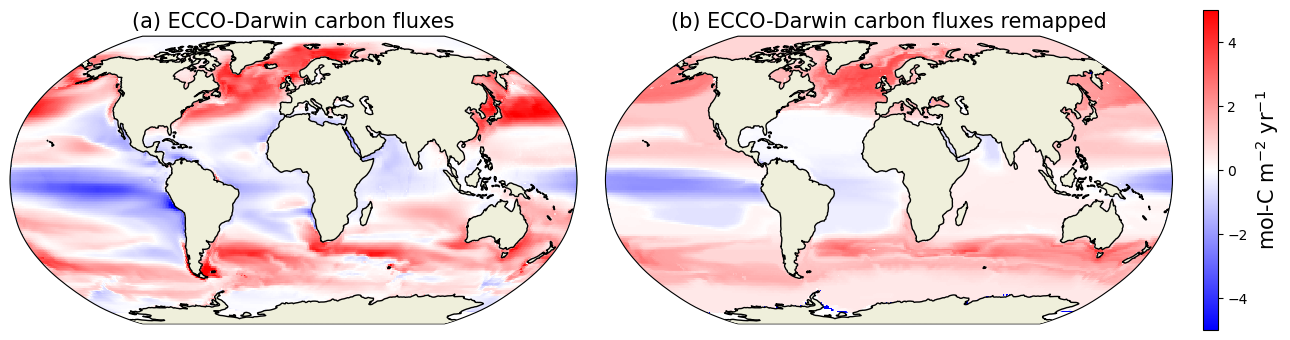

In [6]:
# Plot

fig  = plt.figure(figsize = (15, 4))
gs = gridspec.GridSpec(1,2)
gs.update(wspace = 0.05)
fs=15

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=0))
ax2 = plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=0))

minv, maxv = -5,5

ax1.stock_img()
ax1.coastlines(zorder=101)
ax1.pcolormesh(LON, LAT, CO2flux_interp-sedflux_interp, transform = ccrs.PlateCarree(), vmin=minv, vmax=maxv, cmap=plt.cm.bwr)
ax1.add_feature(cfeature.LAND, zorder=100)
ax1.set_title('(a) ECCO-Darwin carbon fluxes',fontsize=fs)

ax2.stock_img()
ax2.coastlines(zorder=101)
ax2.pcolormesh(LON, LAT, dC_Cflux_flux, transform = ccrs.PlateCarree(), vmin=minv, vmax=maxv, cmap=plt.cm.bwr)
ax2.add_feature(cfeature.LAND, zorder=100)
ax2.set_title('(b) ECCO-Darwin carbon fluxes remapped',fontsize=fs)

cax = fig.add_axes([0.92, 0.12, 0.01, 0.8])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('mol-C m$^{-2}$ yr$^{-1}$',fontsize=fs)

plt.savefig('ECCO_CO2flux_2Dremapping.png', bbox_inches='tight', dpi=300, transparent=True)